# Word Embeddings

1. word2vec-google-news-300 is a pre-trained word embedding model that contains 300-dimensional vectors for 3 million words and phrases.
2. It is trained on Google News dataset (about 100 billion words). About 2gb in size.
3. It is trained using the skip-gram model with negative sampling.

In [1]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')
len(wv['cat'])

300

# Visualization

1. We can visualize the word embeddings using PCA.
2. PCA is a dimensionality reduction technique that projects high-dimensional data into a lower-dimensional space.
3. PCA is utilizing SVD (Singular Value Decomposition) to find the principal components of the data.
4. PCA is applying SVD to the covariance matrix of the data.
5. We may also use t-SNE (t-distributed Stochastic Neighbor Embedding) to visualize the word embeddings.
6. t-SNE is a non-linear dimensionality reduction technique that is well-suited for visualizing high-dimensional data.

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize(words, visualize_fn):
    vector_dict = visualize_fn(words)
    pca = PCA(n_components=2)
    X_new = pca.fit_transform(list(vector_dict.values())).T

    plt.scatter(x=X_new[0], y=X_new[1])
    for i, word in enumerate(vector_dict.keys()):
        plt.text(X_new[0, i], X_new[1, i], word, fontsize=12, ha='right')

to_convert = ['car', 'cat', 'dog', 'king', 'queen', 'man', 'woman']

visualize(to_convert, lambda words: {w: wv[w] for w in words})

# Paul Graham Essays

1. Repo: https://github.com/ofou/graham-essays.git
2. Consists of about 500k words in total

In [2]:
import glob

# load pg essays
essays = []
for file in glob.glob('/home/espacio/essays/*.md'):
    with open(file, 'r') as f:
        essays.append([w.lower() for w in f.read().split()])

print(f"Essays: {len(essays)}, Words: {sum([len(e) for e in essays])}")

Essays: 217, Words: 531866


# Bag of Words

1. Bag of words is a technique that utilizes the counts of words across multiple documents (essays) and a vector is created out of the # of occurences
2. For example, if there are 217 documents, one of word-vector would be of shape (217, 1) and its values would be # of occurences of the respective word in each doc
3. each document is preprocessed to remove certain `stopwords` and infrequent words (frequency <= 1)
4. nltk is used to get a list of stopwords
5. defaultdict is used to create a frequency dictionary and later used to remove words with frequency less than 1

In [3]:
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
import numpy as np

# remove stop words
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
essays = [[w for w in essay if w not in stop_words] for essay in essays]
unique_words = list(set([w for essay in essays for w in essay]))
unique_words = {w: i for i, w in enumerate(unique_words)}

# remove words that appear only once
freqs = defaultdict(int)
for essay in essays:
    for w in essay:
        freqs[w] += 1
essays = [[w for w in essay if freqs[w] > 1] for essay in essays]

BoW = np.zeros((len(essays), len(unique_words)))
for i, essay in enumerate(essays):
    for w in essay:
        BoW[i, unique_words[w]] += 1

print(f"Unique words that appear more than once: {len(freqs)}")
print(f"Top 10 most frequent words: {sorted(freqs.items(), key=lambda x: x[1], reverse=True)[:10]}")

to_convert = ['startup', 'company', 'product', 'market', 'customer', 'team', 'technology']
visualize(to_convert, lambda words: {w: BoW[:, unique_words[w]] for w in words})

Unique words that appear more than once: 15526
Top 10 most frequent words: [('people', 2474), ('one', 2219), ('get', 1751), ('would', 1692), ('work', 1311), ('make', 1267), ('good', 1258), ('something', 1217), ('could', 1093), ('startup', 1083)]


# Tf-idf

1. Tf-idf works simillar to BoW but gives more weightage to rarer Words
2. more info at: https://medium.com/@hari4om/word-embedding-d816f643140
3. We use gensim to obtain the respective weight-adjusted counts (scores)

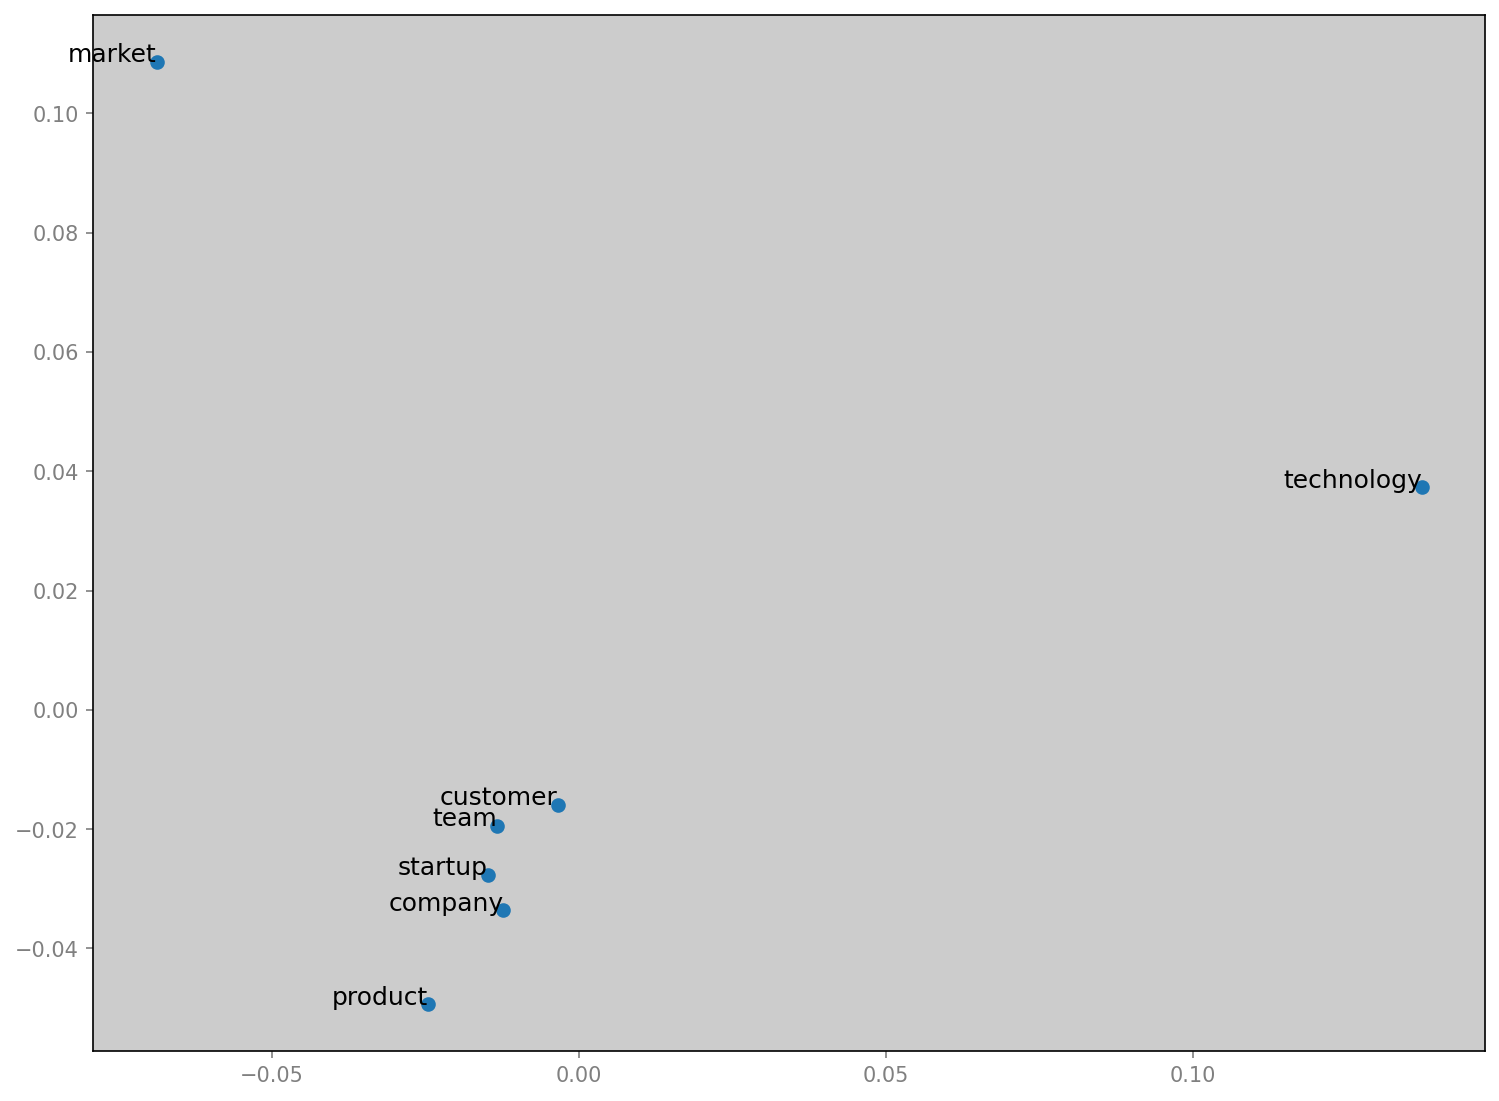

In [4]:
from gensim import corpora
from gensim.models import TfidfModel

dictionary = corpora.Dictionary(essays)
corpus = [dictionary.doc2bow(essay) for essay in essays]

model = TfidfModel(corpus)
corpus_tfidf = model[corpus]

tfidf = np.zeros((len(essays), len(unique_words)))
for i, essay in enumerate(corpus_tfidf):
    for w, score in essay:
        tfidf[i, w] = score
visualize(to_convert, lambda words: {w: tfidf[:, unique_words[w]] for w in words})

# Word2Vec

1. Word2Vec revolutionsed word embeddings. It works on the principle of neural networks
2. The two common types of word2vec models are: Continuous bag of words (CBOW) & skip-gram
3. skip-gram is more commonly used since a greater number of samples can be fed into it from the same dataset
4. We utilize gensim to train the model for us and store it in a local directory named `models`

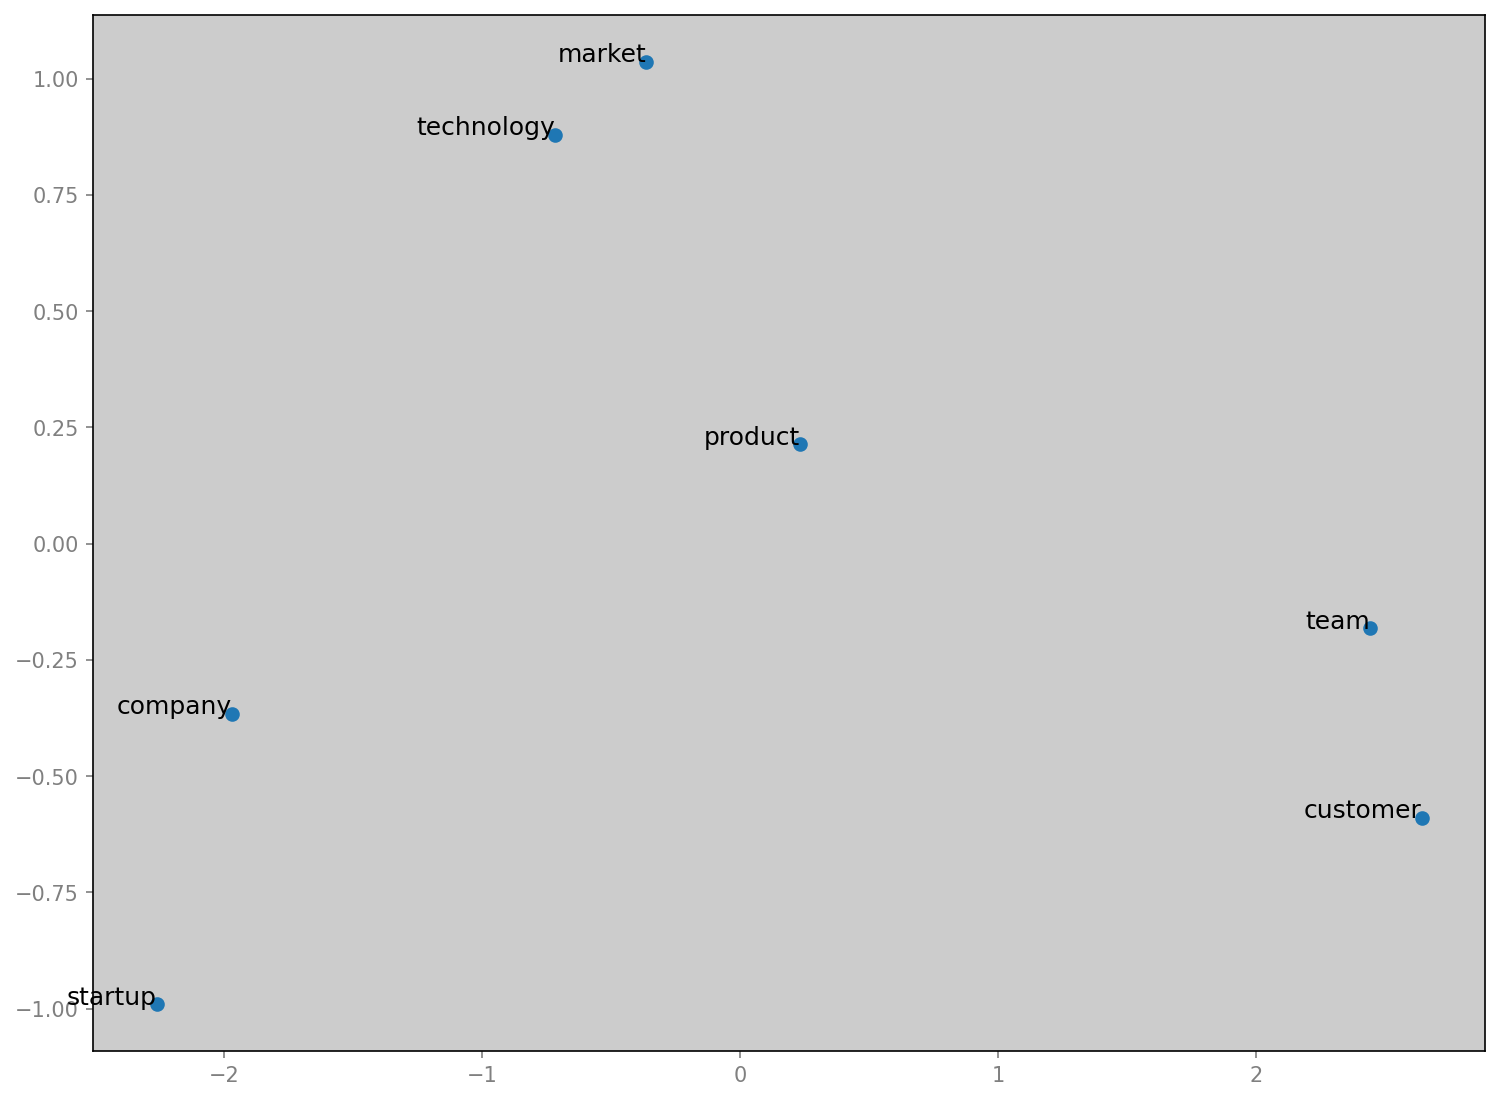

In [5]:
from gensim.models import Word2Vec
import os

model_path = r'models/word2vec.model'
if not os.path.exists(model_path):
    model = Word2Vec(essays, min_count=1)
    model.save(model_path)
else:
    model = Word2Vec.load(model_path)

wv = model.wv
visualize(to_convert, lambda words: {w: wv[w] for w in words})

# Transformer Embeddings

1. Word embeddings learnt while training a large language model (llm)
2. langchain allows us to very easily use HuggingFace & OpenAI word embeddings

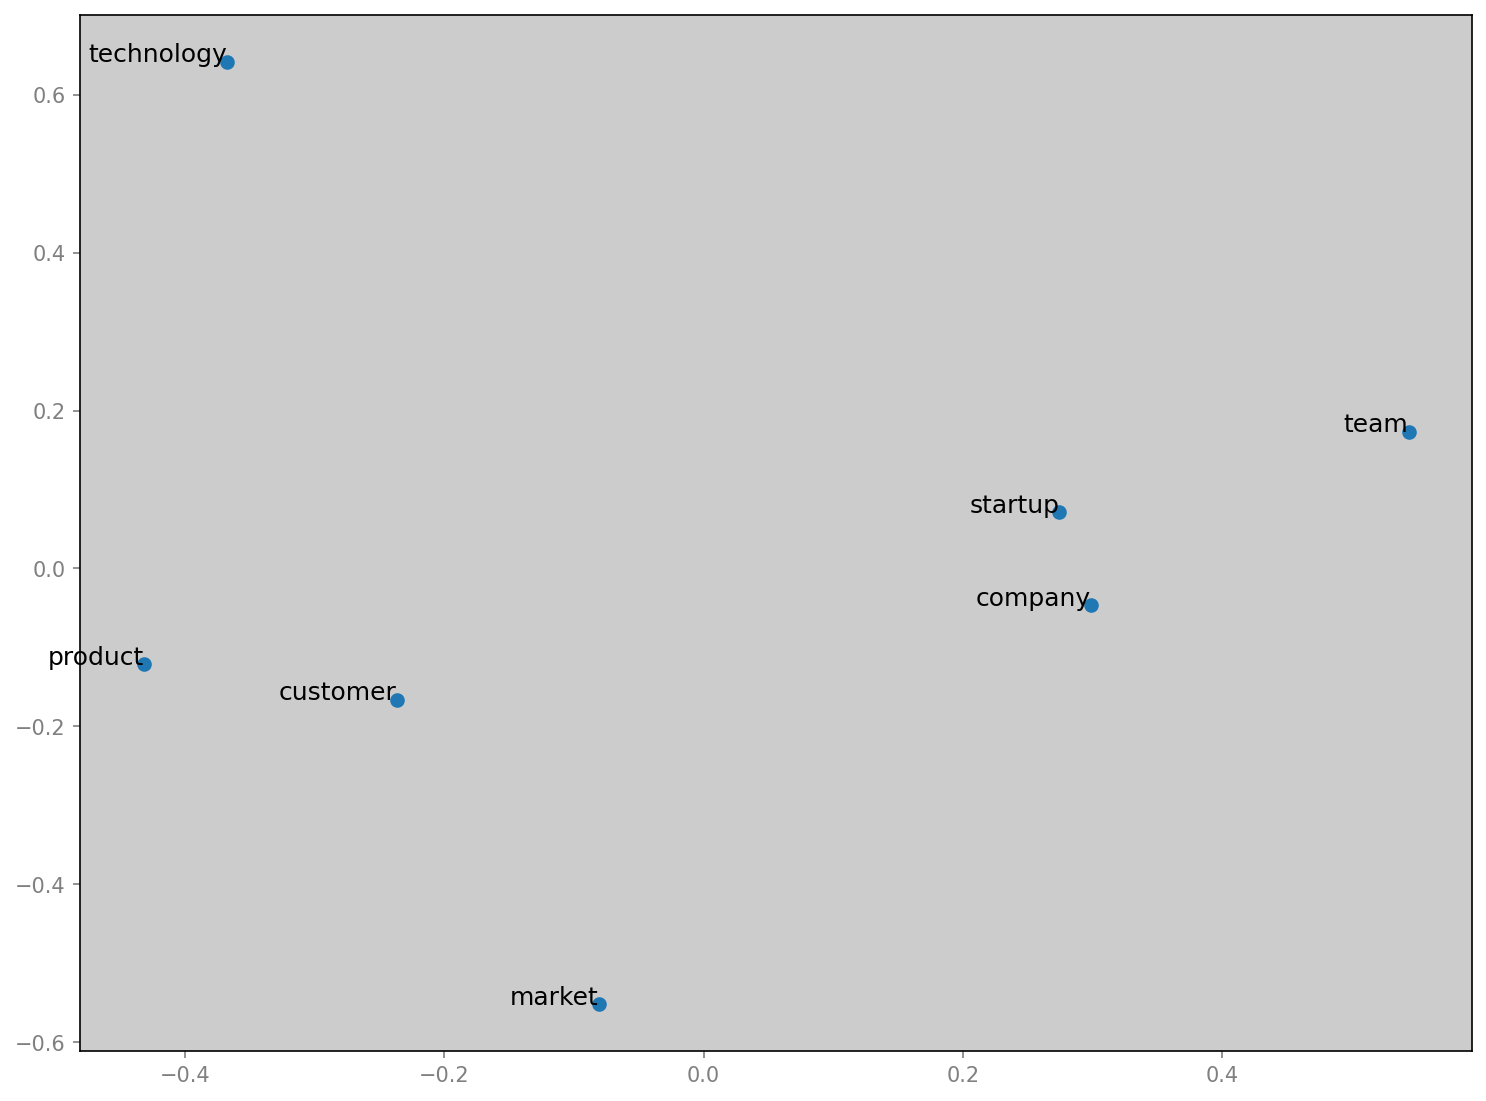

In [6]:
from langchain.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings()
visualize(to_convert, lambda words: {w: embeddings.embed_query(w) for w in words})